In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = np.loadtxt('R0E1CA.txt')
data = data.T

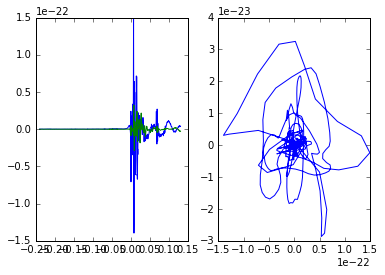

In [11]:
f, ax = plt.subplots(1,2)
ax[0].plot(data[0], data[1])
ax[0].plot(data[0], data[2])
ax[1].plot(data[1], data[2])

In [8]:
import sys
from optparse import OptionParser

import numpy as np
import scipy.signal as signal
import scipy.interpolate as interp

import lal
import lalsimulation as lalsim

In [31]:
times = data[0]
hplus = data[1]
hcross = data[2]
times -= times[0]

#

Ixx, Ixy, Ixz, Iyy, Iyz, Izz = data[5:]

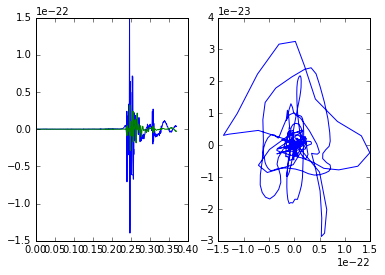

In [13]:
f, ax = plt.subplots(1,2)
ax[0].plot(times, hplus)
ax[0].plot(times, hcross)
ax[1].plot(hplus, hcross)

In [24]:
sample_rate = 16384
extract_dist = 10e-3
step_back = 0.01

interpolator = interp.interp1d(times, hplus)
interp_times = np.arange(0, times[-1], min(np.diff(times)))
hplus_interp = interpolator(interp_times)
hcross_interp = interpolator(interp_times)

target_times = np.arange(0, times[-1], 1.0/sample_rate)
hplus_new = signal.resample(hplus_interp, len(target_times))
hcross_new = signal.resample(hcross_interp, len(target_times))

In [25]:
# Reduce
startidx = np.argmax(abs(hplus_new))-step_back*sample_rate

hplus_new = hplus_new[startidx:]
times_new = target_times[startidx:] - target_times[startidx]

/home/daniel/.virtualenvs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/daniel/.virtualenvs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
# Window
hplus_new*=lal.CreateTukeyREAL8Window(len(hplus_new), 0.25).data.data
hcross_new*=lal.CreateTukeyREAL8Window(len(hcross_new), 0.25).data.data

In [20]:
# I don't know if we actually need this. Check with James
hplus_new /= np.real(lal.SpinWeightedSphericalHarmonic(lal.PI_2, 0, -2, 2, 0))
hcross_new /= np.real(lal.SpinWeightedSphericalHarmonic(lal.PI_2, 0, -2, 2, 0))

In [26]:
# Ditto
massMpc = lal.MRSUN_SI / ( extract_dist * lal.PC_SI * 1.0e6)
hplus_new /= massMpc
times_new /= lal.MTSUN_SI

In [28]:
def construct_Hlm(Ixx, Ixy, Ixz, Iyy, Iyz, Izz, l=2, m=2):
    """
    Construct the expansion parameters Hlm from T1000553.  Returns the expansion
    parameters for l=2, m=m 
    """

    if l!=2:
        print "l!=2 not supported"
        sys.exit()
    if abs(m)>2:
        print "Only l=2 supported, |m| must be <=2"
        sys.exit()

    if m==-2:
        Hlm = np.sqrt(4*lal.PI/5) * (Ixx - Iyy + 2*1j*Ixy)
    elif m==-1:
        Hlm = np.sqrt(16*lal.PI/5) * (Ixx + 1j*Iyz)
    elif m==0:
        Hlm = np.sqrt(32*lal.PI/15) * (Izz - 0.5*(Ixx + Iyy))
    elif m==1:
        Hlm = np.sqrt(16*lal.PI/5) * (-1*Ixx + 1j*Iyz)
    elif m==2:
        Hlm = np.sqrt(4*lal.PI/5) * (Ixx - Iyy - 2*1j*Ixy)

    return Hlm

In [29]:
def interpolate(x_old, y_old, x_new):
    """
    Convenience funtion to avoid repeated code
    """
    interpolator = interp.interp1d(x_old, y_old)
    return interpolator(x_new)

In [39]:
hplus_sim=lal.CreateREAL8TimeSeries('hplus', lal.LIGOTimeGPS(), 0.0,
        1./sample_rate, lal.StrainUnit, len(target_times))

hcross_sim=lal.CreateREAL8TimeSeries('hcross', lal.LIGOTimeGPS(), 0.0,
        1./sample_rate, lal.StrainUnit, len(target_times))

In [81]:
output = np.zeros((len(target_times), 11))

output[:, 0] = target_times

for i, m in enumerate([-2,-1,0,1,2]):
    Hlm = construct_Hlm(Ixx, Ixy, Ixz, Iyy, Iyz, Izz, l=2, m=m)
    #
    # Resample to uniform spacing at 16384 kHz
    #
    Hlm_real = interpolate(times, Hlm.real, target_times)
    Hlm_imag = interpolate(times, Hlm.imag, target_times)
    #
    # Populate time series
    #hplus_sim.data.data  = Hlm_real
    #hcross_sim.data.data = -1*Hlm_imag
    output[:,2*(i+1)-1] = Hlm_real /lal.MRSUN_SI / ( extract_dist * lal.PC_SI * 1e6)
    output[:,2*(i+1)] = -1 * Hlm_imag /lal.MRSUN_SI / ( extract_dist * lal.PC_SI * 1e6)

In [85]:
np.savetxt('decomp.txt', output)